In [1]:
import tensorflow.compat.v1 as tf
tf.compat.v1.disable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, accuracy_score

# Creating a CNN Object
## This part is where we define our network, metrics, activation and the distribution from which we would pick our weights from.
### In this work the weight are picked from glorot_uniform explained in the submitted paper

### relu activation function is used in the hidden layers while the softmax activation function is employed in the output layer


In [2]:
class CNNet(object):
  
  def __init__(self, learning_rate=0.001, input_dim = 28, num_class=10):
    
    # Make hyperparameters instance variables. 
    self.learning_rate = learning_rate
    self.num_class = num_class
    self.input_dim = input_dim
 
    self.initializer = tf.keras.initializers.glorot_uniform()
    self.optimizer = tf.train.AdamOptimizer(self.learning_rate)
    
    # Set Random seed for Tensorflow.
    self.random_seed = 42
    tf.set_random_seed(self.random_seed)


  def network(self, X, activations=False):
    
    with tf.variable_scope('network', initializer=self.initializer):
      
        # Define the layers.
        self.layers = [
            
            tf.layers.Conv2D(filters=16, kernel_size=3,
                                     strides=(1, 1), activation='relu',padding='SAME'),
            
            tf.layers.Conv2D(filters=32, kernel_size=3,
                                     strides=(2, 2), activation='relu'),
            tf.keras.layers.Conv2D(filters=64, kernel_size=3,
                                     strides=(2, 2), activation='relu'),
            tf.keras.layers.Flatten(),
            tf.keras.layers.Dense(self.num_class)
        ]
        
        # Store activations for investigation later.
        activations_list = []
        
        # Forward pass loop, store intermediate activations.
        out = X
        for layer in self.layers:
          out = layer(out)
          activations_list.append(out)
        
        if activations:
          return out, activations_list
        else:
          return out, tf.nn.softmax(out)

  def model(self, X, y):

    # Get the logits from the network.
    out_logits, _ = self.network(X)
   
    # Calculate Cross Entropy loss.
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(
            labels=y, logits=out_logits))
    
    
    # Perform backprop wrt loss and update network variables.
    # Instead of doing optimizer.minimize(loss), explicitly defining
    # which variables are trained.
    grads = self.optimizer.compute_gradients(loss)
    
    vars_list = tf.get_collection(tf.GraphKeys.TRAINABLE_VARIABLES, 
                                  scope="network")
    grad_list = [(g, v) for g, v in grads if v in vars_list]
    optimize_op = self.optimizer.apply_gradients(grad_list)
    
    return loss, optimize_op, out_logits
  
  def metrics(self, y, logits, verbose=True):
    
    # Get prediction values and flatten.
    y = np.argmax(y, axis=1).flatten()
    y_ = np.argmax(logits, axis=1).flatten()

    confusion = confusion_matrix(y_true=y, y_pred=y_)
    accuracy = accuracy_score(y_true=y, y_pred=y_)
    
    if verbose:
      print ("accuracy score: ", accuracy) 
      
    return accuracy
  
  def train(self, train_X, train_y, test_X, test_y, 
            batch_size=256, epochs=100):
    
    # Clear deafult graph stack and reset global graph definition.
    tf.reset_default_graph()
    
    # GPU config.  
    config = tf.ConfigProto()
    config.gpu_options.allow_growth=True
    
    # Placeholders for tensors.
    X = tf.placeholder(shape=[None, self.input_dim, self.input_dim, 1], dtype=tf.float32)
    y = tf.placeholder(shape=[None, self.num_class], dtype=tf.float32)
    
    # Get the ops for training the model.
    loss, optimize, out_logits = self.model(X, y)
     
    self.saver = tf.train.Saver()
    
    # Initialize session.
    with tf.Session(config=config) as sess:
      
      # Initialize the variables in the graph.
      sess.run(tf.global_variables_initializer())
      sess.run(tf.local_variables_initializer())
      
      # Stochastic Gradient Descent loop.
      for step in range(epochs):
        
        # Total number of batch and start index.
        num_train_batches, start = int(train_X.shape[0]/batch_size), 0

        for _ in range(num_train_batches):
          
            # Indexes for batch selection.
            end = start + batch_size         
            limit = end if end < train_X.shape[0] else train_X.shape[0]
            idx = np.arange(start, limit)
            
            # Run optimization op with batch.
            _, step_loss = sess.run([optimize, loss], 
                                    {X: train_X[idx], y: train_y[idx]})
            start = end
        
        print('='*80+'\nEpoch: {0} Training Loss: {1}'.format(step, step_loss))
        
        # Get probabilities and report metrics.
        probs = sess.run(tf.nn.softmax(out_logits), {X: test_X, y: test_y})
        acc = self.metrics(test_y, probs)
        
        self.saver.save(sess, "model.ckpt")
        
      # Get and save representation space for training set.
      probs = sess.run(out_logits, {X: train_X})
      np.save('representations.npy', probs)
      
      return step_loss, acc

  def predict(self, X_test, logits=False, reps=False):
    
    tf.reset_default_graph()
    tf.set_random_seed(42)

    X = tf.placeholder(shape=[None, self.input_dim, self.input_dim, 1], dtype=tf.float32)
    
    # Get the ops for running inference on the model.
    out_logits, out_probs = self.network(X)
    
    saver = tf.train.Saver()
    # Initialize a new session on the graph.
    with tf.Session() as sess:
      
        # Load the trained model into the session to run inference.
        saver.restore(sess, "model.ckpt")
        # Get 
        rep_logits, probs = sess.run([out_logits, out_probs], {X: X_test})
    
    preds = np.argmax(probs, axis=1).flatten()
    if logits:
      return preds, probs
    elif reps:
      return preds, rep_logits
    else:
      return preds

## Training the MNIST train set on the above created network
### 15 epochs chosen below was not arbitarily chosen. I had to plot epochs vs training loss/accuracy alongside validation loss/ accuracy to determine when the validation loss and accuracy stoped improving irrespective of any improve in the training loss. This point served as my optimal epoch for the model. I now modified the code for this number of epochs

In [3]:
from keras.datasets import mnist
from keras.utils import to_categorical

(x_train, y_train), (x_test, y_test) = mnist.load_data()

# Reshape to 4 dimensions and bring intensity to [0,1].
x_train, x_test = x_train.reshape(-1,28,28,1)/255., x_test.reshape(-1,28,28,1)/255.

# Convert labels to one hot encoded vectors.
y_train_oh, y_test_oh = to_categorical(y_train), to_categorical(y_test)

# Train the model for 15 epochs.
mnist_classifier = CNNet()
mnist_classifier.train(x_train, y_train_oh, x_test, y_test_oh, epochs=15)

Epoch: 0 Training Loss: 0.30917853116989136
accuracy score:  0.9593
Epoch: 1 Training Loss: 0.27530235052108765
accuracy score:  0.9748
Epoch: 2 Training Loss: 0.19453750550746918
accuracy score:  0.9798
Epoch: 3 Training Loss: 0.15422022342681885
accuracy score:  0.983
Epoch: 4 Training Loss: 0.12293469905853271
accuracy score:  0.9841
Epoch: 5 Training Loss: 0.10200144350528717
accuracy score:  0.9847
Epoch: 6 Training Loss: 0.08196599036455154
accuracy score:  0.9841
Epoch: 7 Training Loss: 0.05946093052625656
accuracy score:  0.9837
Epoch: 8 Training Loss: 0.04479532688856125
accuracy score:  0.983
Epoch: 9 Training Loss: 0.04748303443193436
accuracy score:  0.9839
Epoch: 10 Training Loss: 0.04002723842859268
accuracy score:  0.9844
Epoch: 11 Training Loss: 0.025269104167819023
accuracy score:  0.9836
Epoch: 12 Training Loss: 0.016846913844347
accuracy score:  0.9859
Epoch: 13 Training Loss: 0.014865424484014511
accuracy score:  0.985
Epoch: 14 Training Loss: 0.02232452668249607
ac

(0.022324527, 0.9866)

## Nice! model accuracy and loss looks good! 98.5%
## Its time to attack as a way of validating the systems trustworthiness.
## For the sake of this research, lets select 10 classified digit of 2 and see how the model performs on it.

In [4]:
# Select 10 samples of digit two from the training set.
mnist_twos = x_train[np.where(y_train == 2)][:10]

# Check if model classifies twos correctly.
orig_preds, orig_logits = mnist_classifier.predict(mnist_twos, logits = True)
orig_probs = np.max(orig_logits, axis=1).tolist()
print('Accuracy of sample of twos: ', accuracy_score(orig_preds, [2]*10))

Accuracy of sample of twos:  1.0


# Generating Avdersarial attack baes on FGSM
## this attack would try to fool the network to classify digit 2 as 6

In [5]:
def fgsm(model, X, target, epsilon):
  # Get logits from the model
  logits, probs = model(X)

  # convert the target to one hot encoded vectors
  target = tf.one_hot(target, 10)

  # Compute the loss between the labels and logits from the model
  loss = - tf.nn.softmax_cross_entropy_with_logits_v2(labels=target, logits=logits)

  # Obtain the gradient of the loss function wrt image
  grad, = tf.gradients(loss, X)

  # get the direction of the gradient and use this to scale the perturbation
  # the output of tf.sign() is as follows -1 if x < 0; 0 if x == 0; 1 if x > 0
  # this helps us know how to manipulate the perturbation ie. in what direction to go.
  perturb = epsilon * tf.sign(grad)

  # update the origianl image with the new perturbation and clip if needed
  X_adv = tf.clip_by_value(X+perturb, 0.0, 1.0)

  return X_adv, perturb


The beautiful function above allows us to pass the image blindly to the model
which obviously does not become classified as a 6, we now calculate the loss, get the gradient of the loss and update with epsilon

##Generate the FGSM

In [6]:
def generate_fgsm(model, inputs, target, epsilon=0.001, epochs=200):
  tf.reset_default_graph()
  tf.set_random_seed(42)

  X = tf.placeholder(shape=[None, 28, 28, 1], dtype=tf.float32)

  # retrive output for the fdsm code implemented above
  adv_op = fgsm(model, X, target, epsilon)

  digits = inputs.reshape(-1, 28, 28, 1)

  with tf.Session() as sess:

    # lets restore the model
    tf.train.Saver().restore(sess, "model.ckpt")

    # iterative loop for the FGSN
    for i in range(epochs):
      digits, pert_iter = sess.run(adv_op, {X: digits})
  
  return digits, pert_iter

## Lets plot and visualize the images
### plot_adversarials plots the original inputs, the perturbations and the adversarial inputs

In [7]:
def plot_adversarials(origs, perturbs, advs , orig_preds, orig_probs, adv_probs, adv_preds, eps):
  
  fig, axes = plt.subplots(ncols=3, nrows=10, figsize=(18,18))

  for i in range(10):
    
    confidence = str(round(orig_probs[i], 2))
    pixels = origs[i].reshape(28,28)
    axes[i][0].imshow(pixels, cmap='gray')
    axes[i][0].set_axis_off()
    title = 'Original\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
    axes[i][0].set_title(title.format(orig_preds[i], confidence))

    pixels = perturbs[i].reshape((28, 28))
    axes[i][1].imshow(pixels, cmap='gray')
    axes[i][1].set_axis_off()
    title = 'Perturbations\n Epsilon: {}' if i==0 else 'Epsilon: {}'
    axes[i][1].set_title(title.format(eps))

    confidence = str(round(adv_probs[i],2))
    pixels = advs[i].reshape((28, 28))
    axes[i][2].imshow(pixels, cmap='gray')
    axes[i][2].set_axis_off()
    title = 'Adversarial\n Predicted: {0} Confidence: {1}' if i==0 else 'Predicted: {0} Confidence: {1}'
    axes[i][2].set_title(title.format(
        adv_preds[i], confidence))
  

  plt.show()



# End to end workflow

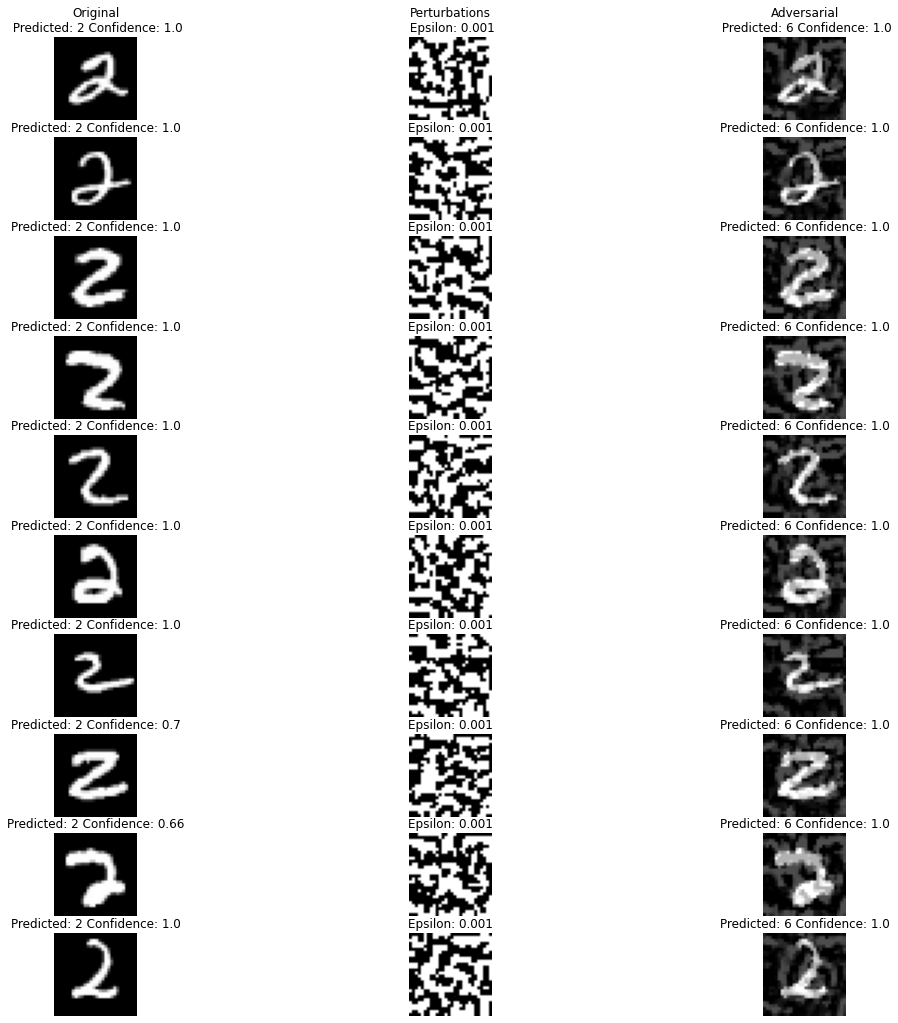

In [8]:
advs_fgsm, perturbs_fgsm = generate_fgsm(mnist_classifier.network, mnist_twos, target=6, epsilon=0.001, epochs=300)

# Making prediction based on the adversarial images gotten from FGSM

preds_fgsm, probs_fgsm = mnist_classifier.predict(advs_fgsm, logits = True)

# converting  predictions and probabilites to lists

preds_fgsm = preds_fgsm.tolist()
probs_fgsm = np.max(probs_fgsm, axis=1).tolist()

# ploting the original image, perturbations and adversarial inputs alongside the model predictions and confidence

plot_adversarials(mnist_twos, perturbs_fgsm, advs_fgsm, 
                  orig_preds, orig_probs, probs_fgsm, preds_fgsm, eps=0.001)

Conclusively, this attacks has successful manipulated the model to miss classify input image as 6 with a very high confidence